In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# exploration 11번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
from numpy.random import randn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose
                                     , Dense, Dropout, Flatten, LeakyReLU, Reshape)
from IPython import display
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 
import matplotlib.pyplot as plt
%matplotlib inline

## 상수선언

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/gen"
SAMPLE_PATH = BASE_PATH + "/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png"
TRAIN_PATH = BASE_PATH + "/training_history/train_history_{:04d}.png"
CHECKPOINT_PREFIX_PATH = BASE_PATH + "/training_checkpoints"
GIF_PATH = BASE_PATH + "/dcgan_v1.gif"
BATCH_SIZE = 256 # rgb_len
V2_LR = 0.0002
TRAIN_SAVE_EVERY = 5
NOISE_DIM = 100 # random sample image dim
GEN_SAMPLE_NUM = 16
DEFAULT_EPOCH = 300
CROSS_ENTROPY = keras.losses.BinaryCrossentropy(from_logits=True)
V1_OPTIMIZER_KWARG = dict(learning_rate=1e-4)
V2_OPTIMIZER_KWARG = dict(learning_rate=V2_LR, beta_1=0.5)

## 함수

In [ ]:
def make_generator_model_v1():
	""" 기존의 모델 """
	# Start
	model = keras.Sequential()

    # First: Dense layer
	model.add(Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
	model.add(BatchNormalization())
	model.add(LeakyReLU())

	# Second: Reshape layer
	model.add(Reshape((8, 8, 256)))

	# Third: Conv2DTranspose layer
	model.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
	model.add(BatchNormalization())
	model.add(LeakyReLU())

	# Fourth: Conv2DTranspose layer
	model.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
	model.add(BatchNormalization())
	model.add(LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
	                                 activation='tanh'))

	return model

def make_discriminator_model_v1():
	""" 기존의 판별자 모델 """
	# Start
	model = tf.keras.Sequential()

	# First: Conv2D Layer
	model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
	model.add(LeakyReLU())
	model.add(Dropout(0.3))

	# Second: Conv2D Layer
	model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU())
	model.add(Dropout(0.3))

	# Third: Flatten Layer
	model.add(Flatten())

	# Fourth: Dense Layer
	model.add(Dense(1))

	return model

def generator_loss(fake_output):
	""" fake_output이 실제 사진에 가까울수록 작은 값을 가짐(0 ~ 1사이의 값). """
	return CROSS_ENTROPY(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
	""" real_output 값을 1백터의 cross entropy,
		fake_output 값을 0백터의 cross entropy
		한 두 loss를 합친 값 
	"""
	real_loss = CROSS_ENTROPY(tf.ones_like(real_output), real_output)
	fake_loss = CROSS_ENTROPY(tf.zeros_like(fake_output), fake_output)
	total_loss = real_loss + fake_loss
	return total_loss

def discriminator_accuracy(real_output, fake_output):
	"""
	real output, fake output의 accuracy 측정
	두 값이 0.5에 수렴해야 이상적인 학습결과이다.
	"""
	real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
	fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
	return real_accuracy, fake_accuracy

def generate_and_save_images(model, epoch, it, sample_seeds):
	"""
	학습된 모델을 이용한 가짜 이미지 생성
	"""
	predictions = model(sample_seeds, training=False)

	fig = plt.figure(figsize=(4, 4))
	for i in range(predictions.shape[0]):
		plt.subplot(4, 4, i+1)
		plt.imshow((predictions[i]+1) /2)
		plt.axis('off')

	plt.savefig(SAMPLE_PATH.format(epoch, it))

	plt.show()

def draw_train_history(history, epoch):
	"""
	학습결과의 그래프 작성
	"""
    # summarize history for loss  
	plt.subplot(211)  
	plt.plot(history['gen_loss'])  
	plt.plot(history['disc_loss'])  
	plt.title('model loss')  
	plt.ylabel('loss')  
	plt.xlabel('batch iters')  
	plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

	# summarize history for accuracy  
	plt.subplot(212)  
	plt.plot(history['fake_accuracy'])  
	plt.plot(history['real_accuracy'])  
	plt.title('discriminator accuracy')  
	plt.ylabel('accuracy')  
	plt.xlabel('batch iters')  
	plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
	# training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
	plt.savefig(TRAIN_PATH.format(epoch))
	plt.show()

######################################################### 개선된 모델 #########################################################

def make_generator_model_v2():
	""" 개선된 모델 """
	model = keras.Sequential(name="v2_gen_model")
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_shape=(NOISE_DIM,)))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

def make_discriminator_model_v2(in_shape=(32,32,3)):
	""" 개선된 모델 """
	model = keras.Sequential(name="v2_disc_model")
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(**V2_OPTIMIZER_KWARG), metrics=['accuracy'])
	return model

def gan_model_v2(g_model, d_model):
	""" 생성 모델과 판별모델을 하나로 합치는 과정"""
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(**V2_OPTIMIZER_KWARG))
	return model

함수의 개선방안은 아래의 링크를 참고하여 제작하였다.<br>
[참고사이트](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

## 메인

### 사진의 분석

170498071/170498071 [==============================] - 13s 0us/step
data shape: (50000, 32, 32, 3)


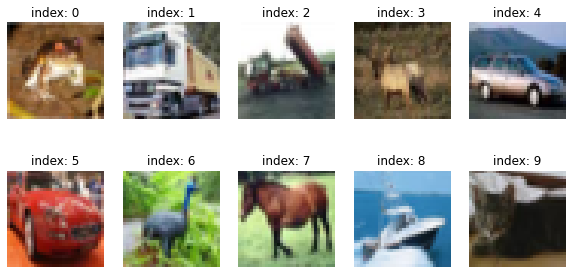

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(f"data shape: {train_x.shape}")

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

데이터는 `keras`에서 기본으로 제공하는 데이터를 사용하였으며<br>
data는 32\*32\*3 칼러 이미지 50,000장<br>
label은 0~9까지의 데이터가 있으며 설명은 아래와 같다.<br>
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

아래의 그림은 확인용으로 그림 10장정도를 그려보았다. 

### 전처리

In [ ]:
train_x = (train_x - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_x.shape[0]).batch(BATCH_SIZE)

미리 학습된 segmentation모델을 로드 후<br>
피사체에 피사체에 해당하는 색으로 칠하였다.<br>
고양이 사진의 경우 변수가 없으므로 완벽하게 피사체를 인식하였다.<br>
여성의 피사체를 일부 누락이 있지만 인식하여 알맞는 색을 칠한 것을 볼 수있다.<br>
이미지에 칠한 색은 아래의 목록을 확인하면 알 수 있다.<br>

### 학습설계

In [ ]:
generator_v1 = make_generator_model_v1()
generator_v1.summary()

print("\n" + "#"*65 + "\n")

generator_v2 = make_generator_model_v2()
generator_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

exploration 예제가 `28*28*3` 과제가 `32*32*3`형태의 그림으로 input값이 변경되었으므로 <br>
초기 input을 `7,7,256` -> `8,8,256`으로 변경시켜 준것 밖에 없다.<br>

개선한 모델의 경우에는 `4,4,256`로 input을 조정해 좀더 연산하는 layer를 늘렸다.<br>
또한 음수값일때의 기울기를 조정하여 학습률을 높혔다.<br>

생성결과 각 레이어의 노드가 줄어든 것에 대해 확인이 가능하다.<br>

non trained image shape: (1, 32, 32, 3)


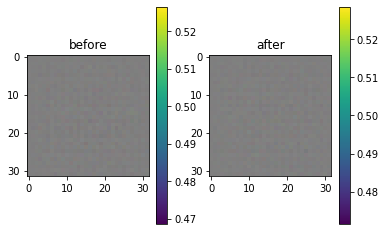

In [ ]:
noise_v1 = tf.random.normal([1, 100], 0, 1) # 균일분포를 통한 랜덤값
noise_v2 = randn(100).reshape(1,-1) # 가우시안 정규분포를 통한 랜덤값
generated_image_v1 = generator_v1(noise_v1, training=False)
generated_image_v2 = generator_v1(noise_v2, training=False)

print(f"non trained image shape: {generated_image_v1.shape}")

plt.subplot(1, 2, 1)
plt.imshow((generated_image_v1[0] + 1) / 2)
plt.title(f'before')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow((generated_image_v2[0] + 1) / 2)
plt.title(f'after')
plt.colorbar()
plt.show()

1\~100까지의 랜덤의 수를 적용시킨 array를 생성한다.<br>
김종태 그루님의 도움으로 랜덤으로 이미지를 생성할 시<br>
(`random 이미지의 백터` + 1) /2 가 이미지의 화소를<br>
0~1사이로 분표시켜 이미지가 잘 보이게 된다는 조언을 듣고 적용하였다.<br>
생성결과 두 사진의 차이는 크게 보이지 않는다.<br>

In [ ]:
discriminator_v1 = make_discriminator_model_v1()
discriminator_v1.summary()

print("\n" + "#"*65 + "\n")

discriminator_v2 = make_discriminator_model_v2()
discriminator_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

위의 생성자 모델과 같이 leaky relu의 α값 조정, 레이어 1층 증가 이외 달라진 점이 없다.<br>

In [ ]:
decision_v1 = discriminator_v1(generated_image_v1, training=False)
print(decision_v1)

print("\n" + "#"*58 + "\n")

decision_v2 = discriminator_v2(generated_image_v2, training=False)
print(decision_v2)

tf.Tensor([[-0.00213337]], shape=(1, 1), dtype=float32)

##########################################################

tf.Tensor([[0.50023496]], shape=(1, 1), dtype=float32)


생성자도 별다른 이상없이 동작이 가능한 것을 볼 수 있다.

In [ ]:
generator = make_generator_model_v1()
discriminator = make_discriminator_model_v1()
generator_optimizer = Adam(**V1_OPTIMIZER_KWARG)
discriminator_optimizer = Adam(**V1_OPTIMIZER_KWARG)
seed = tf.random.normal([GEN_SAMPLE_NUM, NOISE_DIM])

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

def train_v1(dataset, save_every, epochs):

	start = time.time()
	history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

	for epoch in range(epochs):
		epoch_start = time.time()
		for it, image_batch in enumerate(dataset):
			gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
			history['gen_loss'].append(gen_loss)
			history['disc_loss'].append(disc_loss)
			history['real_accuracy'].append(real_accuracy)
			history['fake_accuracy'].append(fake_accuracy)

			if it % 50 == 0:
				display.clear_output(wait=True)
				generate_and_save_images(generator, epoch+1, it+1, seed)
				print('Epoch {} | iter {}'.format(epoch+1, it+1))
				print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

		if (epoch + 1) % save_every == 0:
			checkpoint.save(file_prefix=CHECKPOINT_PREFIX_PATH)

		display.clear_output(wait=True)
		generate_and_save_images(generator, epochs, it, seed)
		print('Time for training : {} sec'.format(int(time.time()-start)))

		draw_train_history(history, epoch)


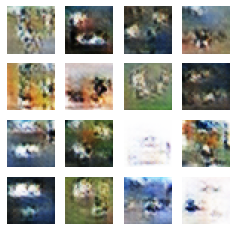

Time for training : 3810 sec


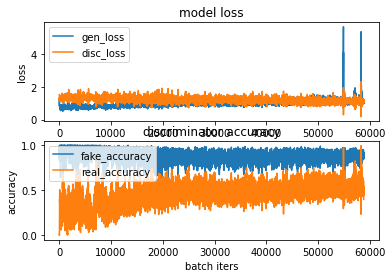

In [ ]:
train_v1(train_dataset, TRAIN_SAVE_EVERY, DEFAULT_EPOCH)

In [ ]:
with imageio.get_writer(GIF_PATH, mode='I') as writer:
    filenames = glob.glob(BASE_PATH + "/generated_samples/sample*.png")
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

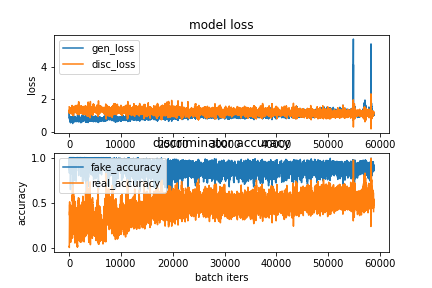
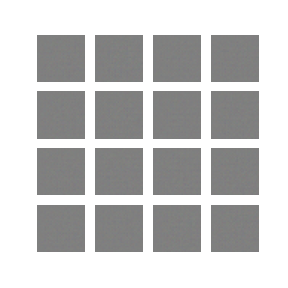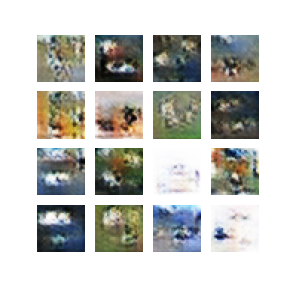
<br>학습과정의 그래프와 이미지를 나타냈다.<br>

### 회고


- `@tensorflow.function`의 동작 메커니즘에 대해 알게되었다.<br>
코드를 함수부와 실행부를 나누어 동작시키려 했지만 아래의 요인으로 인하여 3일을 소비하였다.
        - 함수 안의 변수(특히 모델)의 경우는 함수 실행전에 선언해주어야 한다.
        - `checkpoint`의 키 값은 실행시 영향이 없지만, 저장한 모델을 불러올시 에러가 발생함
        - 함수의 파라미터 부분에 변수가 아닌 생성된 인스턴스를 넣을경우 에러가 발생하며 동작하지 않는다.
        - 함수에 모델, 체크포인트 등을 넣으면 에러가 발생한다.
위의 에러에 관련되어 `stack overflow`와 주변에 관련 전공자 그루분들에게<br> 물어봐도 해답을 받지 못하였고 결국 자력으로 해결하였다.
- 후반부의 epoch부분의 특이값은 문제는 분석이 불가능하여 다른 그루분들에게 물어볼 예정이다.